In [16]:
import numpy as np
import scipy.sparse as spsp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.linalg import lu
from scipy.sparse import diags

# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

### 1.1

In [2]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones; add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.

def band_lu(diag_broadcast, n):
    if len(diag_broadcast) == 3:
        d = np.ones(n) * diag_broadcast[1]
        b = np.ones(n-1) * diag_broadcast[2]
        a = np.ones(n) * diag_broadcast[0]
        a[-1] = 0

        dd = np.empty(n)
        bb = np.empty(n-1)

        dd[0] = d[0]

        for i in range(1, n):
            bb[i-1] = b[i-1] / dd[i-1]
            dd[i] = d[i] - bb[i-1] * a[i-1]

        L = bb.reshape((1, n-1))
        U = np.vstack((dd, a)).T

        return L, U
    
    elif len(diag_broadcast) == 5:
        a = np.ones(n) * diag_broadcast[0]
        b = np.ones(n) * diag_broadcast[1]
        c = np.ones(n) * diag_broadcast[2]
        d = np.ones(n) * diag_broadcast[3]
        e = np.ones(n) * diag_broadcast[4]

        a[:2] = np.zeros(2)
        b[0] = 0
        d[-1] = 0
        e[-2:] = np.zeros(2)

        f = np.zeros(n)
        g = np.zeros(n)
        h = np.zeros(n)
        k = np.zeros(n)
        l = e

        for i in range(n):
            if i == 0:
                h[i] = c[i]
                k[i] = d[i]
            elif i == 1:
                g[i] = b[i] / h[i-1]
                k[i] = d[i] - g[i] * l[i-1]
                h[i] = c[i] - g[i] * k[i-1]
            else:
                f[i] = a[i] / h[i-2]
                g[i] = (b[i] - f[i] * k[i-2]) / h[i-1]
                h[i] = c[i] - f[i] * l[i-2] - g[i] * k[i-1]
                k[i] = d[i] - g[i] * l[i-1]

        L = np.vstack((g[1:], np.roll(f[1:], -1)))
        U = np.vstack((h, k, l)).T

        return L, U
    
    else:
        raise NotImplementedError() 

In [3]:
diag_broadcast_3 = [-1, 2, -1]
diag_broadcast_5 = [-1, 2, -1, -4, 9]

def matrix_from_diags(diag_broadcast, n):
    if len(diag_broadcast) == 3:
        return np.eye(n) * diag_broadcast[1] + np.diag(np.ones(n-1) * diag_broadcast[0], -1) + \
    np.diag(np.ones(n-1) * diag_broadcast[2], 1)
    
    elif len(diag_broadcast) == 5:
        return np.eye(n) * diag_broadcast[2] + np.diag(np.ones(n-1) * diag_broadcast[1], -1) + \
    np.diag(np.ones(n-1) * diag_broadcast[3], 1) + np.diag(np.ones(n-2) * diag_broadcast[0], -2) + \
    np.diag(np.ones(n-2) * diag_broadcast[4], 2)

### 1.2

In [64]:
from tqdm.notebook import tqdm
from scipy.linalg import lu

ours_time_3 = []
sp_time_3 = []
ours_time_5 = []
sp_time_5 = []
n_range = np.linspace(10, 1000, 10, dtype=int)

for n in tqdm(n_range):
    A = matrix_from_diags(diag_broadcast_3, n)
    ours = %timeit -oq band_lu(diag_broadcast_3, n)
    ours_time_3.append(ours.average)
    sp = %timeit -oq lu(A)
    sp_time_3.append(sp.average)
    
    A = matrix_from_diags(diag_broadcast_5, n)
    ours = %timeit -oq band_lu(diag_broadcast_5, n)
    ours_time_5.append(ours.average)
    sp = %timeit -oq lu(A)
    sp_time_5.append(sp.average)

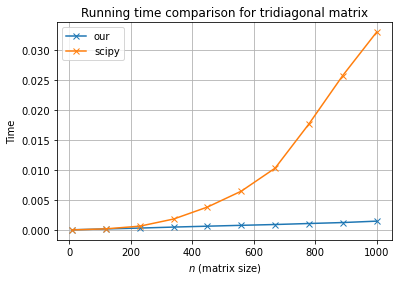

In [84]:
import matplotlib.pyplot as plt

plt.plot(n_range, ours_time_3, marker='x')
plt.plot(n_range, sp_time_3, marker='x')
plt.title('Running time comparison for tridiagonal matrix')
plt.xlabel('$n$ (matrix size)')
plt.ylabel('Time')
plt.legend(['our', 'scipy'])
plt.grid();

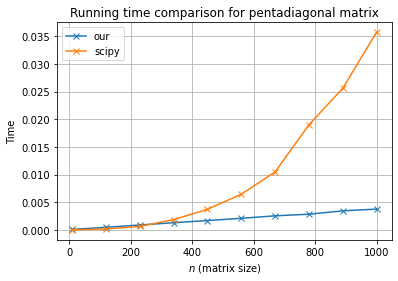

In [86]:
plt.plot(n_range, ours_time_5, marker='x')
plt.plot(n_range, sp_time_5, marker='x')
plt.title('Running time comparison for pentadiagonal matrix')
plt.xlabel('$n$ (matrix size)')
plt.ylabel('Time')
plt.legend(['our', 'scipy'])
plt.grid();

As can be seen, our implementation is a much faster, than a scipy version. SciPy doesn't know about matrix structure, so it works $O(n^3)$, however, our implementation complexity is $O(n)$.

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

## 2.1

Without pivoting:

1. $A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}$ => 
$\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1 - \frac{1}{\varepsilon} & 1 \\
0 & 1 & 1
\end{pmatrix}$ = 
$\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\
0 & 1 & 1
\end{pmatrix}$ = 
$\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\
0 & 0 & 1 - \frac{\varepsilon}{\varepsilon - 1}
\end{pmatrix}$ = 
$\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\
0 & 0 & \frac{1}{1 - \varepsilon}
\end{pmatrix}$ = $U$

2. $L = \begin{pmatrix}
1 & 0 & 0\\
l_1 & 1 & 0 \\
l_2 & l_3 & 1
\end{pmatrix}$

3. $a_{21} = 1 = l_1 \varepsilon + 1 \times 0 + 0 \times 0 = l_1 \varepsilon => l_1 = \frac{1}{\varepsilon}$
$\\ a_{33} = 1 = l_2 \times 0 + l_3 \times 1 + 1\times \frac{1}{1 - \varepsilon} = l_3 + \frac{1}{1 - \varepsilon} => l_3 = 1 - \frac{1}{1 - \varepsilon} = \frac{\varepsilon}{\varepsilon - 1}$
$\\ a_{32} = 1 = l_2 \times 1 + l_3 \times \frac{\varepsilon - 1}{\varepsilon} + 1 \times 0 = l_2 + \frac{\varepsilon}{\varepsilon - 1} \times \frac{\varepsilon - 1}{\varepsilon} = l_2 + 1 => l_2 = 0$

4. $L = \begin{pmatrix}
1 & 0 & 0\\
\frac{1}{\varepsilon} & 1 & 0 \\
0 & \frac{\varepsilon}{\varepsilon - 1} & 1
\end{pmatrix}$,
$U =\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\
0 & 0 & \frac{1}{1 - \varepsilon}
\end{pmatrix}$


With pivoting:

1. $A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}$,
$P = \begin{pmatrix}
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}$, 
$U = A$, $L = I$

2. Swap rows 1 and 2:
$\\ U = \begin{pmatrix}
1 & 1 & 1\\
\varepsilon & 1 & 0 \\
0 & 1 & 1
\end{pmatrix} \to
\begin{pmatrix}
1 & 1 & 1\\
0 & 1 - \varepsilon & - \varepsilon \\
0 & 1 & 1
\end{pmatrix}$
$\\ L = \begin{pmatrix}
1 & 0  & 0\\
\varepsilon & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}$
$P = \begin{pmatrix}
0 & 1 & 0\\
1 & 0 & 0 \\
0 & 0 & 1
\end{pmatrix}$

3. Swap rows 2 and 3:
$\\ U = \begin{pmatrix}
1 & 1 & 1\\
0 & 1 & 1 \\
0 & 1 - \varepsilon & - \varepsilon
\end{pmatrix} \to
\begin{pmatrix}
1 & 1 & 1\\
0 & 1 & 1 \\
0 & 0 & -1
\end{pmatrix} $
$\\ L = \begin{pmatrix}
1 & 0  & 0\\
0 & 1 & 0 \\
\varepsilon & 1 - \varepsilon & 1
\end{pmatrix}$
$P = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1 \\
1 & 0 & 0
\end{pmatrix}$

4. $L = \begin{pmatrix}
1 & 0  & 0\\
0 & 1 & 0 \\
\varepsilon & 1 - \varepsilon & 1
\end{pmatrix}$,
$U = \begin{pmatrix}
1 & 1 & 1\\
0 & 1 & 1 \\
0 & 0 & -1
\end{pmatrix} $,
$P = \begin{pmatrix}
0 & 1 & 0\\
0 & 0 & 1 \\
1 & 0 & 0
\end{pmatrix}$


## 2.2

LU decomposition can fail for the following example:

$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}$ => 
$\begin{pmatrix}
\varepsilon & 1 & 0\\
0 & 1 - \frac{1}{\varepsilon} & 1 \\
0 & 1 & 1
\end{pmatrix}$

We try to subtract $\frac{1}{\varepsilon}$ from $1$. As $|\varepsilon|\ll 1$, $\frac{1}{\varepsilon}$ is something large, comparing to $1$. So, we have a trouble for dealing with large and small numbers.

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

## 3.1

1. Suppose, $A_{11}^{-1}$ exists.
2. $T = \begin{bmatrix} I & 0 \\ -A_{21}A_{11}^{-1} & I \end{bmatrix} => TA = \begin{bmatrix} A_{11} & A_{12} \\ 0 & S \end{bmatrix}$, where $S = A_{21}A_{11}^{-1}A_{12} + A_{22}$
3. $Tf = \begin{bmatrix} f_1 \\ -A_{21}A_{11}^{-1}f_1 + f_2 \end{bmatrix} => \hat{f_2} = -A_{21}A_{11}^{-1}f_1 + f_2$

## 3.2

1. Compose the block matrix $M =\begin{bmatrix} I & -B \\ A & X \end{bmatrix} \to \begin{bmatrix} I & -B \\ 0 & X + AB\end{bmatrix} => \det(M) = \begin{vmatrix} I & -B \\ 0 & X + AB \end{vmatrix} = \det(I) \det(X + AB) = \det(X + AB)$

2. Using Schur complement property, $\det(M) = \det(X) \det(I + BX^{-1}A)$

3. Using conclusions from 1 and 2, $\det(M) = \det(X + AB) = \det(X) \det(I + BX^{-1}A)$

4. But let's prove Schur complement property

5. Let $P = \begin{bmatrix} A & B \\ C & D\end{bmatrix}$ and $L = \begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix}$

6. Then $PL = \begin{bmatrix} A - BD^{-1}C & B \\ 0 & D\end{bmatrix} = \begin{bmatrix} I & BD^{-1} \\ 0 & I \end{bmatrix} \begin{bmatrix} A - BD^{-1}C & 0 \\ 0 & D\end{bmatrix} => P = \begin{bmatrix} I & BD^{-1} \\ 0 & I \end{bmatrix} \begin{bmatrix} A - BD^{-1}C & 0 \\ 0 & D\end{bmatrix} \begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix}$

7. $\det(P) = \det(\begin{bmatrix} I & BD^{-1} \\ 0 & I \end{bmatrix} \begin{bmatrix} A - BD^{-1}C & 0 \\ 0 & D\end{bmatrix} \begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix}) = \det(\begin{bmatrix} I & BD^{-1} \\ 0 & I \end{bmatrix}) \det(\begin{bmatrix} A - BD^{-1}C & 0 \\ 0 & D\end{bmatrix}) \det(\begin{bmatrix} I & 0 \\ -D^{-1}C & I \end{bmatrix}) = 1 \times \det(\begin{bmatrix} A - BD^{-1}C & 0 \\ 0 & D\end{bmatrix}) \times 1 = \det(\begin{bmatrix} A - BD^{-1}C & 0 \\ 0 & D\end{bmatrix}) = \det(A - BD^{-1}C) \det(D)$

## 3.3

1. $\begin{vmatrix} I_n & G \\ F & I_m \end{vmatrix} = \begin{vmatrix} I_n & G \\ 0 & I_m - FG \end{vmatrix} = \det(I_n) \det(I_m - FG) = \det(I_m - FG)$

2. $\begin{vmatrix} I_n & G \\ F & I_m \end{vmatrix} = \begin{vmatrix} I_n - GF & 0 \\ F & I_m \end{vmatrix} = \det(I_m) \det(I_n - GF) = \det(I_n - GF)$

3. As can be seen from the 1 and 2, $\det(I_m - FG) = \det(I_n - GF)$

### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

### 4.1
The idea is a simple. Vectorize it!

In [7]:
# Your solution is here

import numpy as np

eps = 1e-4#1.12e-16
a = [[eps, 1],[1.0,  1]]
a = np.array(a)
a0 = a.copy()

def naive_LU(a):
    n = a.shape[0]
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    for k in range(n): #Eliminate one row   
        L[k, k] = 1
        for i in range(k+1, n):
            L[i, k] = a[i, k] / a[k, k]
            for j in range(k+1, n):
                a[i, j] += -L[i, k] * a[k, j]
        for j in range(k, n):
            U[k, j] = a[k, j]
            
    return L, U

L, U = naive_LU(a)
print('L * U - A:\n', np.dot(L, U) - a0)
L, U

L * U - A:
 [[0. 0.]
 [0. 0.]]


(array([[1.e+00, 0.e+00],
        [1.e+04, 1.e+00]]),
 array([[ 1.000e-04,  1.000e+00],
        [ 0.000e+00, -9.999e+03]]))

### 4.2 

In [2]:
def efficient_LU(A):
    N = A.shape[0]
    A_prev = A.copy()
    L = np.eye(N)
    
    for n in range(N-1):
        L_cur = np.eye(N)
        i = n + 1
        L_cur[i:, n] = -A_prev[i:, n] / A_prev[n, n]
        L[i:, n] = A_prev[i:, n] / A_prev[n, n]
        
        A_cur = L_cur @ A_prev
        A_prev = A_cur
        
    return L, A_cur

### 4.3

In [3]:
L, U = efficient_LU(a)
np.linalg.norm(L @ U - a)

0.0

### 4.4

In [19]:
from scipy.linalg import lu
from tqdm.notebook import tqdm

N_num = 10
N_range = np.linspace(10, 500, N_num, dtype=int)
time = np.zeros((3, N_num))

for N_ind, N in enumerate(tqdm(N_range)):
    A_rand = np.random.rand(N ** 2).reshape((N, N))
    
    t = %timeit -oq efficient_LU(A_rand)
    time[0, N_ind] = t.average
    
    t = %timeit -oq naive_LU(A_rand)
    time[1, N_ind] = t.average
    
    t = %timeit -oq lu(A_rand)
    time[2, N_ind] = t.average

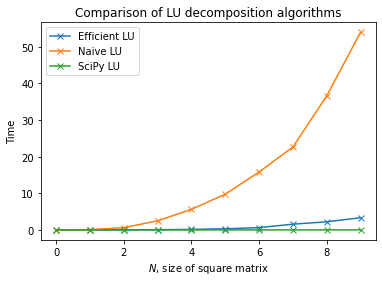

In [21]:
plt.plot(range(N_num), time[0], marker='x')
plt.plot(range(N_num), time[1], marker='x')
plt.plot(range(N_num), time[2], marker='x')
plt.legend(['Efficient LU', 'Naive LU', 'SciPy LU'])
plt.xlabel('$N$, size of square matrix')
plt.ylabel('Time')
plt.title('Comparison of LU decomposition algorithms');

###  4.5
Another possible trick to accelerate LU decomposition is an usage of block implementation.

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

### 1.1

1. $A$ - normal matrix => $A = U \Lambda U^*$
2. Eigenvalues are real and $\Lambda$ is a diagonal => $\Lambda^* = \Lambda$
3. $A^* = (U \Lambda U^*)^* = ((U \Lambda) U^*)^* = U(U \Lambda)^* = U \Lambda^* U^* = \{\Lambda^* = \Lambda\ \} = U \Lambda U^*$
4. $A = A^* => A$ (normal matrix) is Hermitian

1. $A$ - normal matrix => $A = U \Lambda U^*$, where $U$ is an unitary matrix
2. $A^* = (U \Lambda U^*)^* = ((U \Lambda) U^*)^* = U(U \Lambda)^* = U \Lambda^* U^*$
3. $AA^* = U \Lambda U^* U \Lambda^* U^* = \{UU^* = I\} = U \Lambda \Lambda^* U^*$
4. $\Lambda \Lambda^* = \Lambda^* \Lambda$ - diagonal matrix with diagonal $(|\lambda_1|, |\lambda_2|, ..., |\lambda_n|) = (1, ..., 1)$ => $\Lambda \Lambda^* = I$
5. $AA^* = U \Lambda \Lambda^* U^* = UU^* = I$
6. $A^*A = U \Lambda^* U^* U \Lambda^* U^* = \{U^*U = I\} = U \Lambda^* \Lambda U^* = UU^* = I$
7. $AA^* = A^*A = I => A$ (normal matrix) is an unitary matrix

### 1.2

1. Find eigenvalues of $J$: $|J - eI| = 0$,  where e - eigenvalue (because $\lambda$ is a constant in $J$)
$ \\
    J - eI = 
    \begin{bmatrix} 
     \lambda - e & 1 & & & 0 \\ 
     & \lambda - e & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda - e & 1 \\ 
     \varepsilon & & & & \lambda - e  \\ 
    \end{bmatrix}_{n\times n}
$

$\\ |J - eI| = (\lambda - e)^n + (-1)^{n+1}\varepsilon = 0$
$\\ (\lambda - e)^n = (-1)^n\varepsilon$
$\\ (e - \lambda)^n = \varepsilon$
$\\ (e - \lambda) = (\pm)^{n-1} \varepsilon^{\frac{1}{n}}$
$\\ e = (\pm 1)^{n-1} \varepsilon^{\frac{1}{n}} + \lambda$

2. $n \to \infty$
$\\ e \to \lambda + (\pm 1)^{n-1}$

3. As can be seen from the eigenvalue for large $n$, if we change a little bit matrix (adding $\varepsilon$), eigenvalues will perturbed from $\lambda$ to $\lambda \pm 1$.

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

### 2.1

In [22]:
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    # enter your code here
    if type(G) == np.ndarray:
        return G / G.sum(axis=0)
    elif type(G) == spsp.csr_matrix:
        G = G.T
        col_sum = G.sum(axis=0).A1
        zero_cnt = col_sum[col_sum == 0].shape[0]
        col_sum[col_sum == 0] = np.ones(zero_cnt)
        col_sum = 1 / col_sum
        norm_diag = spsp.diags(col_sum)
        
        return G @ norm_diag

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

### 2.2

In [34]:
G = np.zeros((5, 5))
G[0, 1] = 1
G[1, 2] = 1
G[2, 0] = 1
G[2, 1] = 1
G[3, 4] = 1
G[4, 3] = 1

A = pagerank_matrix(G)
A

array([[0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [1. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1. , 0. ]])

In [24]:
np.linalg.eigvals(A)

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

$\lambda = 1$ is a maximal eigenvalue, which mupliplicity is equal to 2.

### 2.3

In [25]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    # enter your code here
    x_prev = x0
    x = x0
    res = np.zeros(num_iter + 1)
    
    A_dot_x0 = A @ x0
    l = A_dot_x0 @ x0
    res[0] = np.linalg.norm(A_dot_x0 - l * x0)
    
    for i in tqdm(range(num_iter)):
#         print(i)
        A_dot_x_prev = A @ x_prev
        x = A_dot_x_prev / np.linalg.norm(A_dot_x_prev)
        
        A_dot_x = A @ x
        l = A_dot_x @ x
        res[i+1] = np.linalg.norm(A_dot_x - l * x)
        
        x_prev = x
    
    return x, l, res

In [26]:
x, l, res = power_method(np.array([[2, -1], [-1, 2]]), np.random.rand(2), 100)
l

3.0

* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

### 2.4

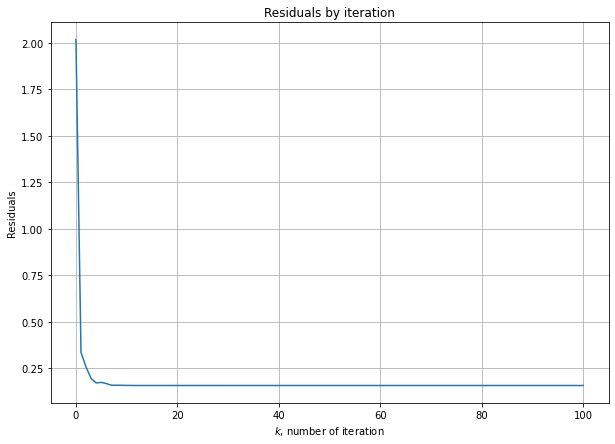

In [27]:
x, l, res = power_method(pagerank_matrix(G), np.random.rand(G.shape[0]), 100)

plt.figure(figsize=(10, 7))
plt.plot(np.arange(101), res)
plt.title('Residuals by iteration')
plt.ylabel('Residuals')
plt.xlabel('$k$, number of iteration')
plt.grid();

In [35]:
np.linalg.eigvals(pagerank_matrix(G))

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ])

Largest absolute eigenvalues are 1 and -1

### 2.5

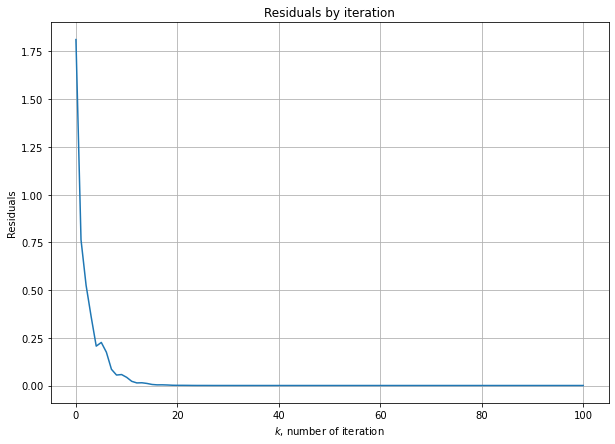

In [28]:
G[4, 4] = 1
x, l, res = power_method(pagerank_matrix(G), np.random.rand(G.shape[0]), 100)
plt.figure(figsize=(10, 7))
plt.plot(np.arange(101), res)
plt.title('Residuals by iteration')
plt.ylabel('Residuals')
plt.xlabel('$k$, number of iteration')
plt.grid();

In [31]:
np.linalg.eigvals(pagerank_matrix(G))

array([-0.5+0.5j, -0.5-0.5j,  1. +0.j , -0.5+0.j ,  1. +0.j ])

Largest absolute eigenvalues are 1 and 1

In [25]:
different_x0 = np.random.rand(G.shape[0] * 10).reshape((10, G.shape[0]))
evecs = []
for x0 in different_x0:
    evecs.append(power_method(pagerank_matrix(G), x0, 100)[0])
evecs

[array([0.15472368, 0.30944737, 0.30944737, 0.43510409, 0.77151129]),
 array([0.26839443, 0.53678885, 0.53678885, 0.40177838, 0.43618118]),
 array([0.10964145, 0.2192829 , 0.2192829 , 0.16913083, 0.92908747]),
 array([0.26917439, 0.53834878, 0.53834878, 0.31627032, 0.4978749 ]),
 array([0.20095283, 0.40190566, 0.40190566, 0.63876493, 0.47805962]),
 array([0.26525818, 0.53051636, 0.53051636, 0.50663495, 0.33175881]),
 array([0.27141419, 0.54282837, 0.54282837, 0.45819719, 0.35646093]),
 array([0.27221607, 0.54443214, 0.54443214, 0.54747866, 0.18262755]),
 array([0.27364049, 0.54728099, 0.54728099, 0.52739397, 0.21896008]),
 array([0.24530576, 0.49061153, 0.49061153, 0.26279398, 0.62399124])]

If there are some largest absolute eigenvalues, convergence depends on sign of these eigenvalues.
If signs are different (as before adding self-loop), power method doesn't converge (because it gives a vector that is a linear combination of corresponding eigenvectors); otherwise, signs are the same and power method converges.

### 2.6

In [26]:
def A_d(A, d):
    N = A.shape[0]
    return d * A + (1 - d) / N * np.ones((N, N))

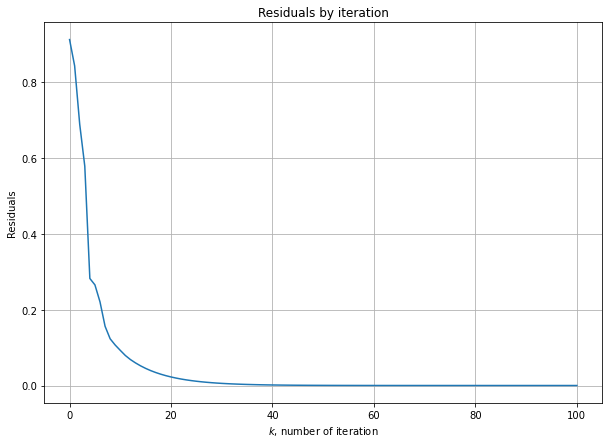

In [28]:
x, l, res = power_method(A_d(pagerank_matrix(G), d=0.87), np.random.rand(G.shape[0]), 100)

plt.figure(figsize=(10, 7))
plt.plot(np.arange(101), res)
plt.title('Residuals by iteration')
plt.ylabel('Residuals')
plt.xlabel('$k$, number of iteration')
plt.grid();

### 2.7

In [29]:
abs_eigvals = sorted(np.abs(np.linalg.eigvals(A_d(pagerank_matrix(G), d=0.97))), reverse=True)
abs_eigvals[1]

0.97

The second largest in the absolute value eigenvalue of the obtained matrix $A_d$ is equal to the damping factor $d$.

In [31]:
"Convergence ratio is equal to {}".format((abs_eigvals[1] / abs_eigvals[0]) ** 100)

'Convergence ratio is equal to 0.047552507925408355'

### 2.8

In [32]:
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    # enter your code here
    N = x.shape[0]
    return d * A @ x + (1 - d) * np.ones(N) * x.sum() / N

### 2.9

In [33]:
sp_A = spsp.random(10000, 10000, density=1e-6).tocsr()
x = np.random.rand(10000)
d = 0.97
sp_A_d = A_d(sp_A.todense(), d)

%timeit pagerank_matvec(sp_A, d, x)
%timeit sp_A_d @ x

sp_A_d_dot_x = pagerank_matvec(sp_A, d, x)
A_d_dot_x =  sp_A_d @ x

np.linalg.norm(sp_A_d_dot_x - A_d_dot_x.A1)

230 µs ± 36.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
98.4 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


3.4938640006908055e-15

In [34]:
sp_A_d_dot_x.shape, A_d_dot_x.A1.shape

((10000,), (10000,))

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

### 2.10

In [4]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [5]:
'Density is equal to {}'.format(G.nnz / G.shape[0] ** 2)

'Density is equal to 4.4986518152305776e-05'

In [6]:
author_weights = G.sum(axis=0).A1
top10_cited_author_ids = sorted(list(zip(np.arange(author_weights.shape[0]), author_weights)), key=lambda x: x[1])[-10:]

In [7]:
authors[np.array(top10_cited_author_ids, dtype=int)[:, 0]][::-1]

array(['Scott Shenker', 'Andrew Zisserman', 'Hari Balakrishnan',
       'Jiawei Han', 'Anil K. Jain', 'Cordelia Schmid', 'Jitendra Malik',
       'Ion Stoica', 'David E. Culler', 'David G. Lowe'], dtype='<U98')

In [8]:
pagerank_G1 = pagerank_matrix(spsp.csr_matrix((np.ones(G.nnz), G.indices, G.indptr), shape=G.shape))

In [9]:
del G

In [10]:
pagerank_G1.shape

(1766547, 1766547)

We can see that simple adding number of citations and PageRank method give the different top-10 cited authors. It seems that PageRank method considers a more deep connections between authors.

### 2.11

In [11]:
from scipy.sparse.linalg import LinearOperator
L = LinearOperator(pagerank_G1.shape, matvec=lambda x, A=pagerank_G1, d=0.85: pagerank_matvec(A, d, x))

### 2.12

In [14]:
x, l, res = power_method(L, np.ones(pagerank_G1.shape[0]), 20)

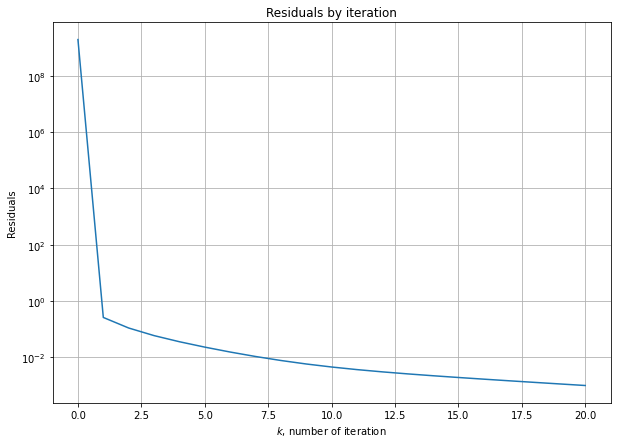

In [17]:
plt.figure(figsize=(10, 7))
plt.plot(range(len(res)), res)
plt.title('Residuals by iteration')
plt.ylabel('Residuals')
plt.xlabel('$k$, number of iteration')
plt.yscale('log')
plt.grid();

### 2.13

In [19]:
pagerank_top10_cited_author_ids = sorted(list(zip(np.arange(x.shape[0]), x)), key=lambda y: y[1])[-10:]
authors[np.array(pagerank_top10_cited_author_ids, dtype=int)[:, 0]][::-1]

array(['David E. Goldberg', 'Richard M. Karp', 'John E. Hopcroft',
       'Azriel Rosenfeld', 'Ronald L. Rivest', 'Anil K. Jain',
       'Takeo Kanade', 'Alfred V. Aho', 'Robert Endre Tarjan',
       'Gerard Salton'], dtype='<U98')

### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below

In [45]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    # enter your code here
    Ak = A_init
    convergence = np.zeros(num_iter)
    
    for i in range(num_iter):
        Q, R = np.linalg.qr(Ak)
        Ak = R @ Q
        convergence[i] = np.linalg.norm(np.tril(Ak, k=-1), np.inf)
    
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [55]:
# Your solution is here
ones = np.ones(11)
symm_matr = np.diag(2*ones) + np.diag(-ones[1:], -1) + np.diag(-ones[1:], 1)

Ak,convergence = qr_algorithm(symm_matr, 400)

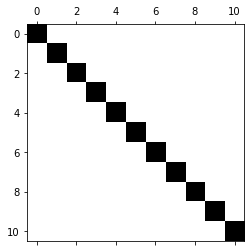

In [56]:
plt.spy(Ak, precision=1e-7)

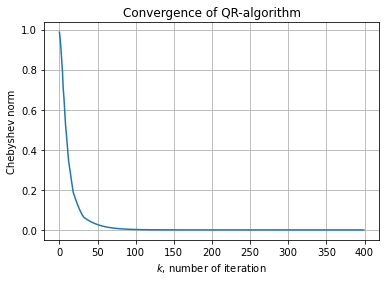

In [57]:
plt.plot(np.arange(convergence.shape[0]), convergence)
plt.xlabel('$k$, number of iteration')
plt.ylabel('Chebyshev norm')
plt.title('Convergence of QR-algorithm')
plt.grid();

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [60]:
# Your solution is here
ones = np.ones(11)
symm_matr = np.diag(3*ones) + np.diag(5*ones[1:], -1) + np.diag(-2*ones[1:], 1)

Ak,convergence = qr_algorithm(symm_matr, 250)

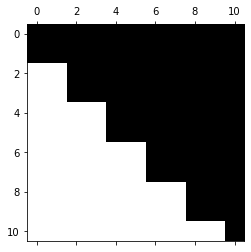

In [61]:
plt.spy(Ak, precision=1e-7)

No, the matrix is an upper triangular.

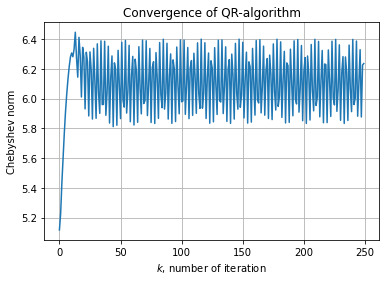

In [62]:
plt.plot(np.arange(convergence.shape[0]), convergence)
plt.xlabel('$k$, number of iteration')
plt.ylabel('Chebyshev norm')
plt.title('Convergence of QR-algorithm')
plt.grid();

I haven't found any info how it corresponds to convergence of QR algorithm.

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redefine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.

- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 



- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.


## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


In [4]:
# Your solution is here
N = 5000
x = np.linspace(0, 1, N) / (N - 1)
x, y = np.meshgrid(x, x)

A = np.exp(-np.sqrt(x**2 + y**2))
A.shape

(5000, 5000)

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


In [101]:
# Your solution is here
def easy_skeleton(A, r, max_iter=100):
    N = A.shape[0]
    for i in range(max_iter):
        row_index_set = np.random.randint(0, N-1, r)
        col_index_set = np.random.randint(0, N-1, r)

        submatrix = A[np.ix_(row_index_set, col_index_set)]
        try:
            A_hat_inv = np.linalg.inv(submatrix)
            break
        except:
            continue
    
    if i == max_iter-1:
        raise Exception
    else:
        return A[:, col_index_set], A_hat_inv, A[row_index_set, :]

In [103]:
M = 1000
relative_errors = np.zeros(M)
for i in tqdm(range(M)):
    C, A_hat_inv, R = easy_skeleton(A, 5)
    relative_errors[i] = np.linalg.norm(A - C @ A_hat_inv @ R, 'fro') / np.linalg.norm(A, 'fro')

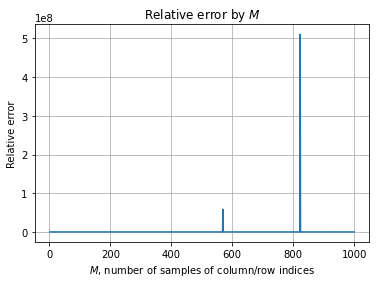

In [114]:
plt.plot(np.arange(1, M+1), relative_errors)
plt.xlabel('$M$, number of samples of column/row indices')
plt.ylabel('Relative error')
plt.title('Relative error by $M$')
plt.grid();

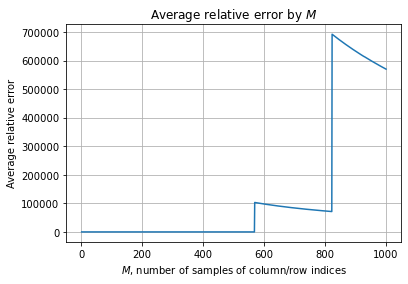

In [112]:
avg_relative_errors = np.cumsum(relative_errors) / np.arange(1, M+1)
plt.plot(np.arange(1, M+1), avg_relative_errors)
plt.xlabel('$M$, number of samples of column/row indices')
plt.ylabel('Average relative error')
plt.title('Average relative error by $M$')
plt.grid();

As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

0. Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

1. Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

2. **If $|b_{ij}| > 1 + \delta$, then**:

    Swap rows $i$ and $j$ in $B$ (accrodignly in A). By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 1__.

    **elseif $|b_{ij}| < 1 + \delta$**:
    
    return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 1 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [22]:
def dominant_submatrix_search(A, delta=1e-2, max_iter=1e5, return_convergence=False):
    # Your code is here
    A_copy = np.copy(A)
    N, r = A_copy.shape
    convergence = []
    
    for n_iter in range(max_iter):
        if n_iter == 0:
            while True:
                init_row_indices = np.random.randint(0, N-1, r)
                all_row_indices = np.arange(N)

                new_pos_inds = np.array(list(zip(all_row_indices, all_row_indices)))
                new_pos_inds[init_row_indices, 1] = np.arange(r)
                new_pos_inds[np.arange(r), 1] = init_row_indices

                A_dom = A_copy[init_row_indices]
                A_copy = A_copy[new_pos_inds[:, 1]]
                try:
                    A_dom_inv_init = np.linalg.inv(A_dom)
                    break
                except:
                    continue
            B = A_copy @ A_dom_inv_init
        else:
            u = np.zeros(r).reshape((r, 1))
            u[j] = 1
            v = (A_copy[i, :r] - A_copy[j, :r]).reshape((r, 1))
            
            A_dom_inv = A_dom_inv_init - (A_dom_inv_init @ u @ v.T @ A_dom_inv_init) / (1 + v.T @ A_dom_inv_init @ u)
            B = A_copy @ A_dom_inv
            
        i, j = np.unravel_index(np.argmax(np.abs(B), axis=None), B.shape)
        b_max = abs(B[i, j])
        convergence.append(b_max)
        
        if b_max > 1 + delta:
            B[i] = B[j]
            A_copy[i] = A_copy[j]
            
            save_inds = new_pos_inds[i, 1]
            new_pos_inds[i, 1] = new_pos_inds[j, 1]
            new_pos_inds[j, 1] = save_inds
            
            A_dom = A_copy[:r]
            
            continue
            
        elif b_max < 1 + delta:
            row_indices = sorted(list(zip(new_pos_inds[:, 0], new_pos_inds[:, 1])), key=lambda x: x[1])[:r]
            if return_convergence:
                return row_indices, convergence
            else:
                return row_indices

    row_indices = np.array(sorted(list(zip(new_pos_inds[:, 0], new_pos_inds[:, 1])), key=lambda x: x[1])[:r])[:, 0]
    
    if return_convergence:
        return row_indices, convergence
    else:
        return row_indices

In [23]:
# check the convergence of your implementation on random data
row_indices, convergence = dominant_submatrix_search(np.random.rand(5000, 10), 
                                                     return_convergence=True, 
                                                     max_iter=10000)

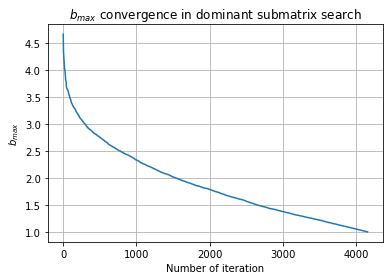

In [24]:
plt.plot(range(len(convergence)), convergence)
plt.xlabel('Number of iteration')
plt.ylabel('$b_{max}$')
plt.title('$b_{max}$ convergence in dominant submatrix search')
# plt.ylim([0, 10])
plt.grid();

- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [25]:
def skeleton(A, r, max_iter=100):
    # Your code is here
    rand_columns_indices = np.random.randint(0, A.shape[1]-1, size=r)
    
    row_indices = dominant_submatrix_search(A[:, rand_columns_indices], max_iter=max_iter)
    column_indices = dominant_submatrix_search(A[row_indices, :].T, max_iter=max_iter)
    
    return row_indices, column_indices

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [26]:
# Your solution is here
%timeit row_indices, col_indices = skeleton(A, 5)

43.4 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
row_indices, col_indices = skeleton(A, 5)
np.linalg.norm(A - A[:, col_indices] @ np.linalg.inv(A[np.ix_(row_indices, col_indices)]) @ A[row_indices, :])

0.0026227500771979903

In [5]:
%time u, s, v = np.linalg.svd(A)

CPU times: user 2min 27s, sys: 989 ms, total: 2min 28s
Wall time: 1min 14s


In [6]:
np.linalg.norm(A - (u * s) @ v)

3.797717112279655e-11

On the one hand, Skeleton decomposition seems to be a much faster, than SVD. On the other hand, SVD has a lower error.